01
['lunettes\n']


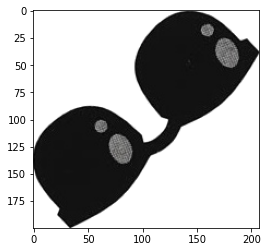

01
['lunettes\n']


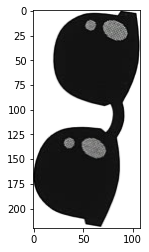

In [1]:
%run Paul.ipynb

####### Center image to object #######

def top_image(img):
    for i in range(len(img)):
        for j in range(len(img[0])):
            if (img[i][j] == 255):
                return i
            
def bottom_image(img):
    for i in reversed(range(len(img) - 1)):
        for j in range(len(img[0])):
            if (img[i][j] == 255):
                return i
            
def left_image(img):
    for i in range(len(img[0])):
        for j in range(len(img)):
            if (img[j][i] == 255):
                return i
            
def right_image(img):
    for i in reversed(range(len(img[0]) - 1)):
        for j in range(len(img)):
            if (img[j][i] == 255):
                return i

def center_image(curr_img):
    top = top_image(curr_img)
    bottom = bottom_image(curr_img)
    left = left_image(curr_img)
    right = right_image(curr_img)
    centered_img = curr_img[top:bottom, left:right]
    return centered_img

In [2]:
###### Resize image without distortion ######

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))
    
    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [4]:
###### Count number of holes ######
    

def count_holes(image):
    img = image.copy()
    img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Threshold the image
    ret,img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(img,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    
    nb_holes = 0
    max_num = np.amax(hierarchy) +1
    for c, h in zip(contours, hierarchy[0]):
        # If there is at least one interior contour, find out how many there are
        if h[2] != -1:
            # Make sure it's not the 'zero' contour
            if h[0] == -1:
                num_interior_contours = max_num - h[2]
            else:
                num_interior_contours = h[0]-h[2]
        else:
            num_interior_contours = 0
    return nb_holes

In [5]:
######### Compute number of components and area size #########

import math

def connected_components(img):
    # load the input image from disk, convert it to grayscale, and
    # threshold it
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    # apply connected component analysis to the thresholded image
    output = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    #print(centroids[1:])
    # initialize an output mask to store all characters parsed from
    # image
    mask = np.zeros(gray.shape, dtype="uint8")
    
    # loop over the number of unique connected component labels, skipping
    # over the first label (as label zero is the background)
    nb_components = 0
    sum_area = 0
    for i in range(1, numLabels):
        # extract the connected component statistics for the current
        # label
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        
        # ensure the width, height, and area are all neither too small
        # nor too big
#         keepWidth = w > 5 and w < 50
#         keepHeight = h > 45 and h < 65
        keepArea = area > 50
        # ensure the connected component we are examining passes all
        # three tests
        if (keepArea):
            nb_components += 1
            sum_area += area
            # construct a mask for the current connected component and
            # then take the bitwise OR with the mask
            #print("[INFO] keeping connected component '{}'".format(i))
            componentMask = (labels == i).astype("uint8") * 255
            mask = cv2.bitwise_or(mask, componentMask)
    return (nb_components, sum_area)
    

In [6]:
######### Compute skeleton #########

def compute_skeleton(img):
    img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Threshold the image
    ret,img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    # Step 1: Create an empty skeleton
    size = np.size(img)
    skel = np.zeros(img.shape, np.uint8)

    # Get a Cross Shaped Kernel
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

    # Repeat steps 2-4
    while True:
        #Step 2: Open the image
        open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
        #Step 3: Substract open from the original image
        temp = cv2.subtract(img, open)
        #Step 4: Erode the original image and refine the skeleton
        eroded = cv2.erode(img, element)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()
        # Step 5: If there are no white pixels left ie.. the image has been completely eroded, quit the loop
        if cv2.countNonZero(img)==0:
            break
    return skel

In [7]:
######### Perform rotation along longest contour #########
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2, h / 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH), borderValue=(255,255,255))

def drawAxis(img, p_, q_, color, scale):
    p = list(p_)
    q = list(q_)

    ## [visualization1]
    angle = math.atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
    hypotenuse = math.sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))

    # Here we lengthen the arrow by a factor of scale
    q[0] = p[0] - scale * hypotenuse * math.cos(angle)
    q[1] = p[1] - scale * hypotenuse * math.sin(angle)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv2.LINE_AA)

    # create the arrow hooks
    p[0] = q[0] + 9 * math.cos(angle + math.pi / 4)
    p[1] = q[1] + 9 * math.sin(angle + math.pi / 4)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv2.LINE_AA)

    p[0] = q[0] + 9 * math.cos(angle - math.pi / 4)
    p[1] = q[1] + 9 * math.sin(angle - math.pi / 4)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv2.LINE_AA)
    ## [visualization1]

def getOrientation(pts, img):
    ## [pca]
    # Construct a buffer used by the pca analysis
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]

    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)

    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    ## [pca]

    ## [visualization]
    # Draw the principal components
#     cv2.circle(img, cntr, 3, (255, 0, 255), 2)
#     p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
#     p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
#     drawAxis(img, cntr, p1, (255, 255, 0), 1)
#     drawAxis(img, cntr, p2, (0, 0, 255), 5)

    angle = math.atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
    ## [visualization]

    # Label with the rotation angle
#     label = "  Rotation Angle: " + str(-int(np.rad2deg(angle)) - 90) + " degrees"
#     textbox = cv2.rectangle(img, (cntr[0], cntr[1]-25), (cntr[0] + 250, cntr[1] + 10), (255,255,255), -1)
#     cv2.putText(img, label, (cntr[0], cntr[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)

    return angle

def rotate_with_contours(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Convert image to binary
    _, bw = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    tmp = cv2.bitwise_not(bw)
    # Find all the contours in the thresholded image
    contours, _ = cv2.findContours(tmp, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    largest_area = 0
    rotation = 0
    for i, c in enumerate(contours):
        # Calculate the area of each contour
        area = cv2.contourArea(c)
        # Ignore contours that are too small or too large
        if area < 1500 or 100000 < area:
            continue

        # Draw each contour only for visualisation purposes
        #cv2.drawContours(img, contours, i, (0, 0, 255), 2)

        # Find the orientation of each shape
        angle = getOrientation(c, img)
        if (largest_area < area):
            largest_area = area
            rotation = angle * 180 / math.pi
    return rotate_bound(img, -rotation)

In [8]:
####### Extract all features from image ######

def features_from_image(image):
    img = image.copy()
    features = []
    
    # compute number of components and area size
    (number_of_components, area_size) = connected_components(img) 
    features.append(number_of_components)
    features.append(area_size)
    
    # compute number of holes
    number_of_holes = count_holes(img)
    features.append(number_of_holes)
    
    # Euler number
    euler_number = number_of_components - number_of_holes
    features.append(euler_number)
    
    # perform rotation based on contours
    rotated = rotate_with_contours(img)
    
    # skeletonize the image
    skeleton = compute_skeleton(rotated)
    
    # center image to object
    centered_img = center_image(skeleton)
    
    # resize image to fixed size (without distortion)
    resized_img = image_resize(centered_img,180,180)
    
    # perform gaussianblur
    blurred_img = cv2.GaussianBlur(resized_img,(5,5),0)
    
    # add some padding to get a squared image
    padded = cv2.copyMakeBorder(blurred_img, 0, 224 - blurred_img.shape[0], 0, 224 - blurred_img.shape[1], cv2.BORDER_CONSTANT, value=[0,0,0])
    features.append(padded)
    
    return np.array(features, dtype=object)

In [9]:
train_topological_features = [features_from_image(train_img) for train_img in train_images]
test_topological_features = [features_from_image(test_img) for test_img in test_images]

In [10]:
from sklearn.dummy import DummyClassifier

early_classifier = DummyClassifier().fit(train_topological_features, train_labels)
early_classifier.score(test_topological_features, test_labels)

0.017543859649122806

In [ ]:
from sklearn.ensemble import RandomForestClassifier

early_classifier = RandomForestClassifier().fit(train_topological_features, train_labels)
early_classifier.score(test_topological_features, test_labels)
